# Normalized Consumption Visualizations

Clayton Miller - miller.clayton@gmail.com

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import timeit
import os
from datetime import datetime
from __future__ import division
from pylab import *
import matplotlib.dates as mdates
from matplotlib import ticker
import datetime
import matplotlib

In [2]:
sns.set_style("whitegrid")

In [3]:
%matplotlib inline

In [4]:
repos_path = "/Users/Clayton/temporal-features-for-buildings/"

In [5]:
meta = pd.read_csv(os.path.join(repos_path,"data/raw/meta_open.csv"), index_col='uid', parse_dates=["datastart","dataend"], dayfirst=True)

In [6]:
temp = pd.read_csv((os.path.join(repos_path,"data/interim/temp_open_utc_complete.csv")), index_col='timestamp', parse_dates=True).tz_localize('utc')

# Individual visualization

In [7]:
def get_individual_data(temp, meta, building):
    timezone = meta.T[building].timezone
    start = meta.T[building].datastart
    end = meta.T[building].dataend
    return pd.DataFrame(temp[building].tz_convert(timezone).truncate(before=start,after=end))

In [8]:
temp_normalized = temp.resample('H').sum()/meta.sqm
#df_normalized = df_normalized

In [9]:
#df_normalized

In [10]:
building = "Office_Ellie"

In [11]:
start = '2012-12-15'
end = '2012-12-30'

In [12]:
df = get_individual_data(temp, meta, building).truncate(before=start,after=end)
df_normalized = get_individual_data(temp_normalized, meta, building).truncate(before=start,after=end)

In [13]:
#df_normalized

In [14]:
def plot_line_example(df_original, df_normalized,  color):
    sns.set(rc={"figure.figsize": (12,4)})
    sns.set_style('whitegrid')
    fig = plt.figure()
    fig.autofmt_xdate()
    fig.subplots_adjust(hspace=.5)
    gs = GridSpec(100,100,bottom=0.18,left=0.18,right=0.88)
    
    df_original.columns = ["Actual kWh"]
    #df_predicted.columns = ["Predicted kWh"]
    ax1 = fig.add_subplot(gs[1:60,:])
    df_original.plot(ax = ax1)
    ax1.xaxis.set_visible(False)
    ax1.set_title("Hourly kWh")
    
    ax2 = fig.add_subplot(gs[68:,:])
    df_normalized = df_normalized.tz_localize(None)
    x = mdates.drange(df_normalized.index[0], df_normalized.index[-1] + datetime.timedelta(hours=1), datetime.timedelta(hours=1))
    y = np.linspace(0, len(df_normalized.columns), len(df_normalized.columns)+1)
    data = np.array(df_normalized.T)
    datam = np.ma.array(data, mask=np.isnan(data))
    cmap = matplotlib.cm.get_cmap(color)
    qmesh = ax2.pcolormesh(x, y, datam, cmap=cmap)
    ax2.set_title("Normalized Hourly Consumption [kWh/m2]")
    
    #leftspacing, 
    cbaxes = fig.add_axes([0.18, 0.08, 0.7, 0.02]) 
    cbar = fig.colorbar(qmesh, ax=ax2, orientation='horizontal', cax=cbaxes)
    
    ax2.axis('tight')
    ax2.xaxis_date()
    ax2.yaxis.set_visible(False)
    myFmt = mdates.DateFormatter('%b %d')
    ax2.xaxis.set_major_formatter(myFmt)

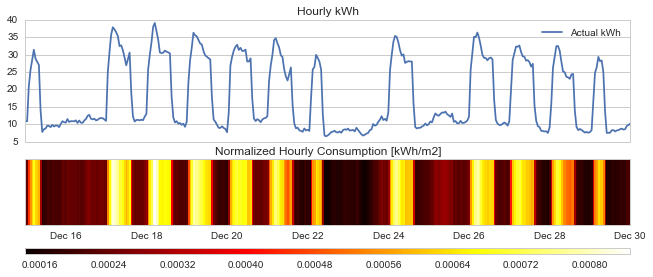

In [17]:
plot_line_example(df, df_normalized, "hot")
plt.savefig(os.path.join(repos_path,"reports/figures/featureoverviews/normalizedcons_example.pdf"));

In [ ]:
#sns.palplot(sns.light_palette("viridis"))

# Overview heatmap

In [48]:
def heatmap_data(df):
    x = mdates.drange(df.index[0], df.index[-1] + datetime.timedelta(days=1), datetime.timedelta(days=1))
    y = np.linspace(0, len(df.columns), len(df.columns)+1)
    return x,y

#This function changes the year for all of the buildings so that they can be overlapped for plotting
# THE RESULTING DATAFRAME IS ONLY FOR "GENERALIZED" PLOTTING TO GET THE DATA SETS TO OVERLAP -- DON'T PERFORM CALCULATIONS ON IT

def changeto2015(x):
    try:
        return x.replace(year=2015)
    except:
        return np.nan
    
def is_leap_and_29Feb(s):
    return (s.index.year % 4 == 0) & ((s.index.year % 100 != 0) | (s.index.year % 400 == 0)) & (s.index.month == 2) & (s.index.day == 29)

def generalize_timestamp_forplotting(meta, temp):
    temp_generalized = pd.DataFrame()
    buildinglist = list(meta.index)
    
    for building in buildinglist:
        #Change to timezone
        timezone = meta.T[building].timezone
        start = meta.T[building].datastart
        end = meta.T[building].dataend
        building_data = pd.DataFrame(temp[building].tz_convert(timezone).truncate(before=start,after=end))
        
        #Remove leap year day for 2012
        mask = is_leap_and_29Feb(building_data)
        building_data = building_data.loc[~mask]
        
        #Change to 2015 -- we arbitrarily use this year
        building_data.index = building_data.index.map(lambda t: changeto2015(t))
        
        #Remove tz awareness, resample to normalize the timestamps and ffill to get rid of the gaps
        building_data = building_data.tz_localize(None)
        building_data = building_data.resample('H').mean().sort_index()
        building_data = building_data.ffill()
        
        #Merge into dataset
        temp_generalized = pd.merge(temp_generalized, building_data, right_index=True, left_index=True, how='outer')
        temp_generalized = temp_generalized.resample('H').mean().sort_index()
        
        #print "finished building: "+building
    return temp_generalized

def plotmap(df, color, cbarlabel, xaxislabel, yaxislabel, graphiclabel, filelabel):
    
    import matplotlib.dates as mdates
    from matplotlib import ticker
    import datetime
    import matplotlib
    import seaborn as sns

    # Set up the size/style
    sns.set(rc={"figure.figsize": (5,11)})
    sns.set_style("whitegrid")
    
    numberofplots = 1
    
    fig = plt.figure()
    
    x = mdates.drange(df.index[0], df.index[-1] + datetime.timedelta(days=1), datetime.timedelta(days=1))
    y = np.linspace(0, len(df.columns), len(df.columns)+1)
    ax = fig.add_subplot(numberofplots, 1, 1)
    data = np.array(df.T)
    datam = np.ma.array(data, mask=np.isnan(data))
    cmap = matplotlib.cm.get_cmap(color)
    qmesh = ax.pcolormesh(x, y, datam, cmap=cmap)
    
    cbaxes = fig.add_axes([0.15, 0.15, 0.7, 0.02]) 
    cbar = fig.colorbar(qmesh, ax=ax, orientation='horizontal', cax=cbaxes)
    
    cbar.ax.tick_params(length = 0)
    cbar.set_label(cbarlabel)
    
    ax.axis('tight')
    ax.xaxis_date()
    fig.autofmt_xdate()
    fig.subplots_adjust(hspace=.5)
    ax.set_xlabel(xaxislabel)
    ax.set_ylabel(yaxislabel)
    ax.set_title(graphiclabel)
    
    ax.set_yticklabels(df.columns)
    tick_locator = ticker.MaxNLocator(nbins=110)
    loc = ticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
    ax.locator_params(axis='y', nbins=100)
    myFmt = mdates.DateFormatter('%b')
    ax.xaxis.set_major_formatter(myFmt)

#     T=np.arange(len(df.columns))+0.5
#     ax.set_yticks(T)
#     plt.tight_layout()
    plt.subplots_adjust(bottom=0.2)
    #plt.savefig(filelabel+".png", dpi=500)

def plotmap_subplots(df, meta, color, cbarlabel, xaxislabel, yaxislabel, graphiclabel, filelabel, z_min, z_max):

    import matplotlib.dates as mdates
    from matplotlib import ticker
    import datetime
    import matplotlib
    import seaborn as sns

    # Set up the size/style
    sns.set(rc={"figure.figsize": (5,11)})
    sns.set_style("whitegrid")
    cmap = matplotlib.cm.get_cmap(color)

    #numberofplots = 1
    
    fig = plt.figure()
    fig.autofmt_xdate()
    fig.subplots_adjust(hspace=.5)
    gs = GridSpec(100,100,bottom=0.18,left=0.18,right=0.88)
    
    # Plot Offices
    df_office = df[df.columns[df.columns.str.contains("Office")]]
    office_height = int(len(df_office.T)/len(df.T)*100-2)
    ax1 = fig.add_subplot(gs[1:office_height,:])
    x,y = heatmap_data(df_office)
    data = np.array(df_office.T)
    datam = np.ma.array(data, mask=np.isnan(df_office))
    qmesh = ax1.pcolormesh(x, y, datam, cmap=cmap, vmin=z_min, vmax=z_max)
#     ax1.set_yticklabels(df_office.columns)
#     numofbins = len(df_office.T)/5
#     tick_locator = ticker.MaxNLocator(nbins=numofbins)
#     loc = ticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
 #   ax1.locator_params(axis='y', nbins=numofbins)
    ax1.axis('tight')
    ax1.xaxis_date()
#     ax1.set_title("Offices")
    ax1.xaxis.set_visible(False)
    
    # Plot UnivLab
    df_lab = df[df.columns[df.columns.str.contains("UnivLab")]]
    lab_height = int(len(df_lab.T)/len(df.T)*100-2)
    ax2 = fig.add_subplot(gs[office_height+2:office_height+lab_height,:])
    x,y = heatmap_data(df_lab)
    data = np.array(df_lab.T)
    datam = np.ma.array(data, mask=np.isnan(df_lab))
    qmesh = ax2.pcolormesh(x, y, datam, cmap=cmap, vmin=z_min, vmax=z_max)
    ax2.axis('tight')
    ax2.xaxis_date()
#     ax2.set_title("University Labs")
    ax2.xaxis.set_visible(False)
    
    # Plot UnivClass
    df_uniclass = df[df.columns[df.columns.str.contains("UnivClass")]]
    uniclass_height = int(len(df_uniclass.T)/len(df.T)*100-2)
    ax3 = fig.add_subplot(gs[office_height+lab_height+2:office_height+lab_height+uniclass_height,:])
    x,y = heatmap_data(df_uniclass)
    data = np.array(df_uniclass.T)
    datam = np.ma.array(data, mask=np.isnan(df_uniclass))
    qmesh = ax3.pcolormesh(x, y, datam, cmap=cmap, vmin=z_min, vmax=z_max)
    ax3.axis('tight')
    ax3.xaxis_date()
#     ax3.set_title("University Classrooms")
    ax3.xaxis.set_visible(False)

    # Plot PrimClass
    df_primclass = df[df.columns[df.columns.str.contains("PrimClass")]]
    primclass_height = int(len(df_primclass.T)/len(df.T)*100-2)
    ax4 = fig.add_subplot(gs[office_height+lab_height+uniclass_height+2:office_height+lab_height+uniclass_height+primclass_height,:])
    x,y = heatmap_data(df_primclass)
    data = np.array(df_primclass.T)
    datam = np.ma.array(data, mask=np.isnan(df_primclass))
    qmesh = ax4.pcolormesh(x, y, datam, cmap=cmap, vmin=z_min, vmax=z_max)
    ax4.axis('tight')
    ax4.xaxis_date()
#     ax4.set_title("Primary/Secondary Classroom")
    ax4.xaxis.set_visible(False)

    
    # Plot Univ Dorms
    df_unidorm = df[df.columns[df.columns.str.contains("UnivDorm")]]
    unidorm_height = int(len(df_unidorm.T)/len(df.T)*100-2)
    ax5 = fig.add_subplot(gs[office_height+lab_height+uniclass_height+primclass_height+2:office_height+lab_height+uniclass_height+primclass_height+unidorm_height,:])
    x,y = heatmap_data(df_unidorm)
    data = np.array(df_unidorm.T)
    datam = np.ma.array(data, mask=np.isnan(df_unidorm))
    qmesh = ax5.pcolormesh(x, y, datam, cmap=cmap, vmin=z_min, vmax=z_max)
    ax5.axis('tight')
    ax5.xaxis_date()
#     ax5.set_title("University Dorms")
    
    cbaxes = fig.add_axes([0.18, 0.23, 0.7, 0.02]) 
    cbar = fig.colorbar(qmesh, orientation='horizontal', cax=cbaxes) #ax=ax,
    
    cbar.ax.tick_params(length = 0)
    cbar.set_label(cbarlabel)

    myFmt = mdates.DateFormatter('%b')
    ax5.xaxis.set_major_formatter(myFmt)
    
    fig.text(0.14, 0.5, yaxislabel, va='center', rotation='vertical')

    #plt.subplots_adjust(bottom=0.2)
    #plt.savefig(filelabel+".png", dpi=500)maps import *

In [49]:
#temp_residuals_normalized.describe().T["count"].value_counts()

In [50]:
#df_normalized

In [51]:
temp_normalized_generalized = generalize_timestamp_forplotting(meta, temp_normalized)

In [52]:
temp_normalized_generalized_sorted = temp_normalized_generalized[list(temp_normalized_generalized.sum().sort_values().index)]

In [53]:
temp_normalized_generalized_sorted.resample("D").sum().describe().T.describe()

,count,mean,std,min,25%,50%,75%,max
count,507.0,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000
mean,365.0,0.343164,0.060326,0.212572,0.292660,0.348147,0.388384,0.474049
std,0.0,0.363428,0.057975,0.295436,0.344141,0.364483,0.388344,0.448987
min,365.0,0.005950,0.000522,0.000102,0.003895,0.006135,0.006745,0.007582
25%,365.0,0.122004,0.030211,0.016784,0.083442,0.131830,0.167037,0.212569
50%,365.0,0.238232,0.047419,0.122704,0.193436,0.241630,0.269012,0.337084
75%,365.0,0.407840,0.072089,0.257058,0.346158,0.412199,0.464675,0.585049
max,365.0,2.523329,0.652775,1.941320,2.361250,2.510396,2.688656,3.010148


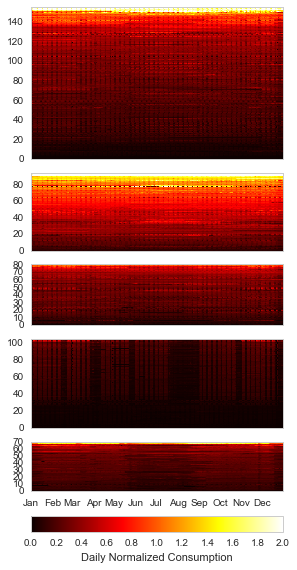

In [54]:
plotmap_subplots(temp_normalized_generalized_sorted.resample("D").sum(), meta, 'hot', "Daily Normalized Consumption",
                 "Timeline", "", "kWh Difference", "Daily Normalized Consumption [kWh/m2]", 0, 2)
plt.savefig(os.path.join(repos_path,"reports/figures/featureoverviews/normalizedcons_heatmap.pdf"));

# Get temporal Features out

In [24]:
temporalfeatures = temp_normalized.resample("D").sum().describe().T

temporalfeatures = temporalfeatures[['mean','std','min','max']]

temporalfeatures.columns = ['BG_normalizedcons_mean','BG_normalizedcons_std','BG_normalizedcons_min','BG_normalizedcons_max']


temporalfeatures.index.name = "building_name"
temporalfeatures.columns.name = "feature_name"

temporalfeatures.to_csv(os.path.join(repos_path,"data/processed/features_normcons.csv"))